In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image

import os

seed_everything(4)

4

# Introduction
In this notebook we'll use a CNN to differentiate between Doom and Animal Crossing memes. We'll also only use images, meaning that we'll ignore some of the available data like number of upvotes, number of comments, date of creation, title, etc.

In this case, instead of going for the standard image classification approach where a probability is predicted for every class (in this case 2 probabilities), we'll try some kind of regression, where the network predicts a single probability. If it is greater than 0.5, it will be classified as a Doom image, otherwise it is an Animal Crossing Image.

To implement all this we'll use pytorch lightning


# The data
The images are taken from the best posts on reddit's [/r/AnimalCrossing](https://reddit.com/r/AnimalCrossing) and [/r/Doom](https://reddit.com/r/Doom) on the month of July 2020. There's all kinds of stuff, from twitter screenshots to posts from one subreddit referencing the other.

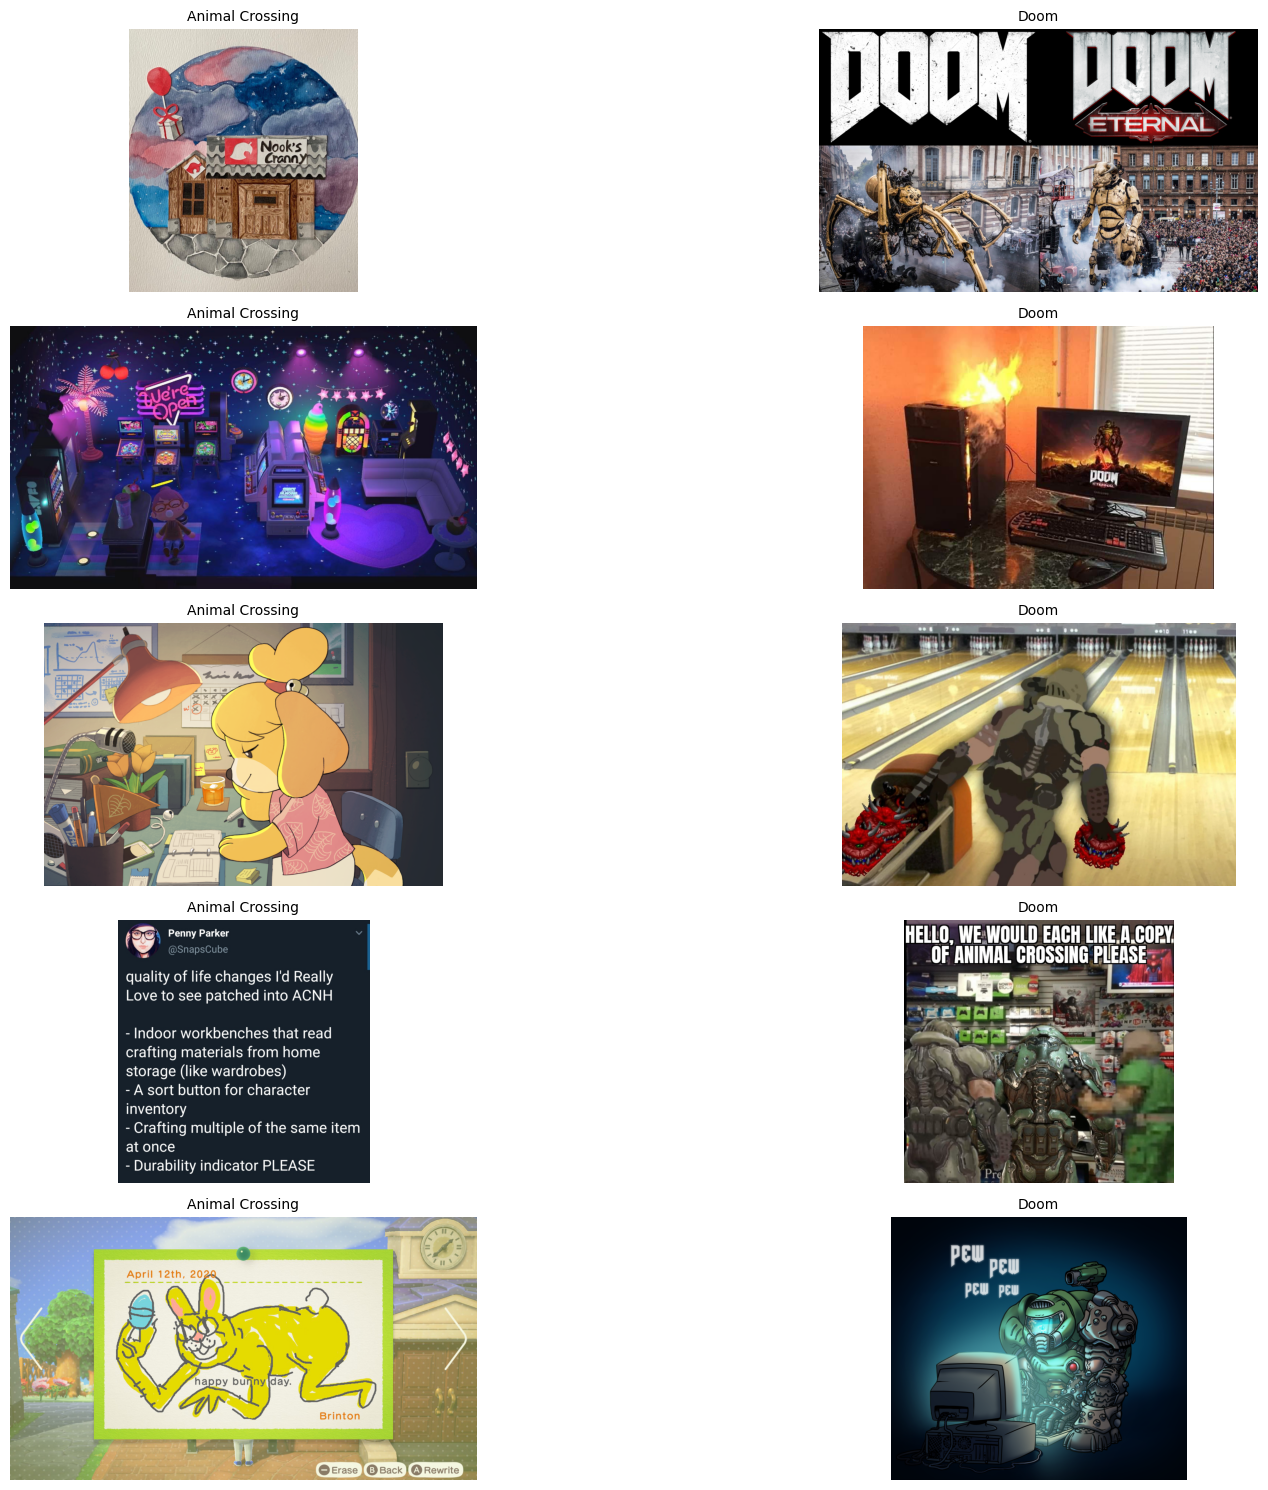

In [2]:
data_path = Path("/kaggle/input/doom-crossing")
df_ac = pd.read_csv(data_path / "animal_crossing_dataset.csv")
df_doom = pd.read_csv(data_path / "doom_crossing_dataset.csv")

num_images = 5
ac_samples = df_ac.sample(num_images, random_state=0)
doom_samples = df_doom.sample(num_images, random_state=0)

fig = plt.figure(figsize=(20,15))
images = []
for (_, ac), (_, doom) in zip(ac_samples.iterrows(), doom_samples.iterrows()):
    with open(data_path / "animal_crossing" / ac["filename"], "rb") as f_ac, open(data_path / "doom" / doom["filename"], "rb") as f_d:
        ac_img, doom_img = Image.open(f_ac), Image.open(f_d)
        ac_img, doom_img = ac_img.convert("RGB"), doom_img.convert("RGB")
        images.extend([ac_img, doom_img])

for i, image in enumerate(images, start=1):
    ax = plt.subplot(num_images, 2, i)
    ax.axis("off")
    ax.set_title("Animal Crossing" if i % 2 != 0 else "Doom", fontsize=10)
    ax.imshow(image)


fig.tight_layout()
fig.show()


# Data Module
First we create a *LightningDataModule* to preprocess the images, split the dataset into train, test and validation and create the dataloaders.

In [3]:
class DoomACLitDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32, image_size=224, seed=4):
        super().__init__()
        self.batch_size = batch_size
        self.image_size = image_size
        self.seed = seed
    
    def prepare_data(self):
        pass
    
    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet values, as our CNN was pretrained on Imagenet
        ])
        
        # Animal crossing = 0, Doom = 1
        dataset = torchvision.datasets.ImageFolder("../input/doom-crossing", transform=transform)
        self.full_dataset = dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, (0.7, 0.15, 0.15), generator=torch.Generator().manual_seed(self.seed))
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=os.cpu_count())
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=os.cpu_count())
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=os.cpu_count())
      

# CNN
Second step is to create the CNN. The architecture of choice is a Resnet50. We adapt it to our problem by freezing the earlier parameters, changing the last layer to output a single number and choosing a loss function fit to predict probabilities in binary classification problems.

In [4]:
class LitResnet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Change last layer
        fc_in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=fc_in_features, out_features=1)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(dim=1) # Convert [batch_size, 1] to [batch_size]
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        self.log("train_loss", loss)
        
        return loss
    
    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(dim=1) # Convert [batch_size, 1] to [batch_size]
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        
        # https://discuss.pytorch.org/t/when-do-i-turn-prediction-numbers-into-1-and-0-for-binary-classification/130075/3
        # Accuracy without converting logits into probabilities
        acc = ((logits > 0.0) == y).float().mean()
        
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
    
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")
    
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=5e-4,
        )
        
        return optimizer

# Training

In [5]:
# Training the model
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)

trainer = pl.Trainer(
    default_root_dir="/kaggle/working",
    accelerator="auto",
    devices="auto",
    max_epochs=50,
    log_every_n_steps=5,
    callbacks=[
        ModelCheckpoint(
            save_weights_only=True,
            mode="max",
            monitor="val_acc",
            dirpath="/kaggle/working/checkpoints",
            filename="{epoch}-{val_loss:.2f}-{val_acc:.2f}"
        ),
        EarlyStopping(
            monitor="val_acc",
            mode="max",
            patience=5,
            verbose=False
        )
    ],
)

dm = DoomACLitDataModule(batch_size=32, image_size=224, seed=0)
dm.setup()

checkpoints = list(Path("/kaggle/working/checkpoints").glob("*.ckpt"))
if checkpoints:
    print("Loading model from checkpoint...")
    checkpoint = max(checkpoints, key=lambda c: c.stat().st_ctime) # Grab the most recent checkpoint
    model = LitResnet.load_from_checkpoint(str(checkpoint.resolve()))
else:
    print("Training...")
    model = LitResnet(lr=5e-5)
    trainer.fit(model, datamodule=dm)
    # Load best checkpoint after training
    model = LitResnet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

Training...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category

Training: 0it [00:00, ?it/s]

[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
trainer.validate(model, datamodule=dm)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:320: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.validate()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│         val_loss          │    0.19290108978748322    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.19290108978748322, 'val_acc': 0.9166666865348816}]

# Evaluating on test images

In [7]:
trainer.test(model, datamodule=dm)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:320: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8583333492279053     │
│         test_loss         │    0.23952999711036682    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.23952999711036682, 'test_acc': 0.8583333492279053}]

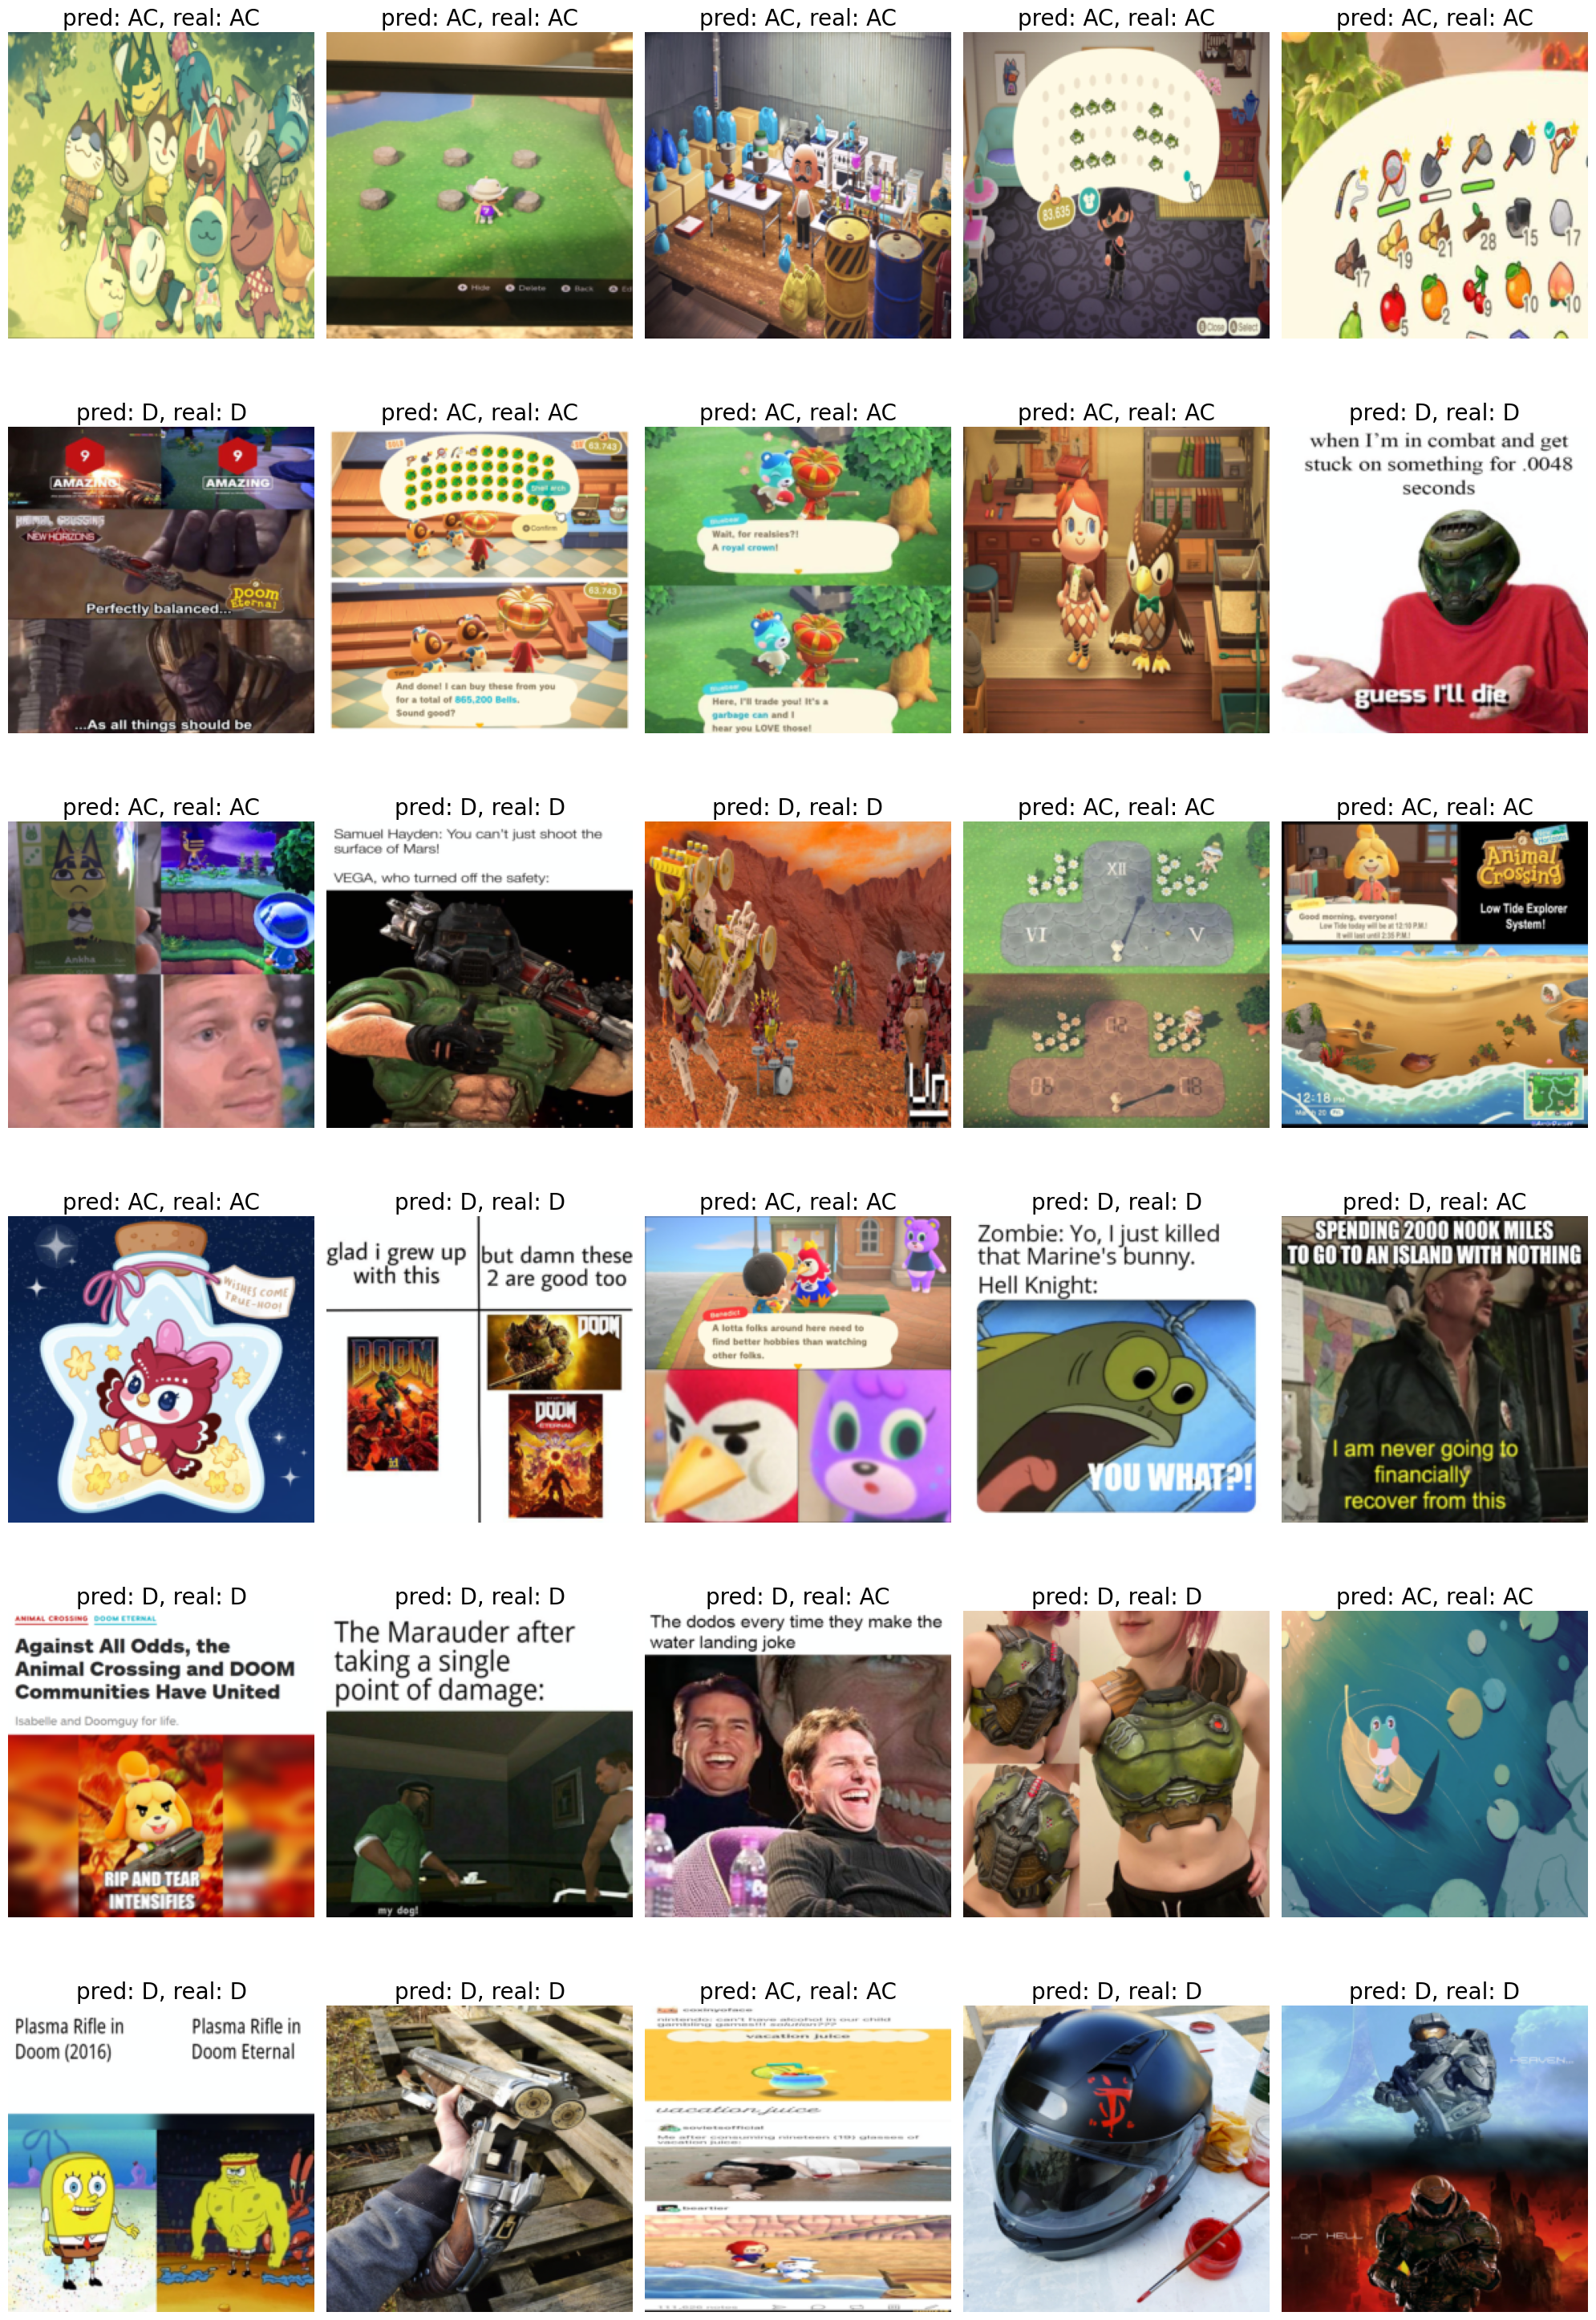

In [8]:
class_names = {
    0: "AC",
    1: "D"
}

def display_image(tensor, ax):
    # Pytorch image format is channels-first, this changes it to channels-last (idx 0 at last position)
    arr = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = arr * std + mean # Undo the Imagenet normalization
    ax.imshow(arr)


def visualize_predictions(model, dataloader, num_images=6):
    fig = plt.figure(figsize=(20,30))
    plotted_images = 0

    for inputs, labels in dataloader:
            
        logits = model(inputs)
        logits = logits.squeeze(dim=1)
        preds = (logits > 0.0).int().tolist()
        
        for i in range(inputs.size()[0]):
            plotted_images += 1
            ax = plt.subplot(- (-num_images // 5), 5, plotted_images)
            ax.axis("off")
            ax.set_title(f"pred: {class_names[preds[i]]}, real: {class_names[labels.tolist()[i]]}", fontsize=20)
            display_image(inputs[i], ax)
                         
            if plotted_images >= num_images:
                fig.tight_layout()
                fig.show()
                return

visualize_predictions(model, dm.test_dataloader(), num_images=30)

# Conclusion
The model performed well on test data. The misclassified images seem to be cases where the images have color palettes that are different than usual. Doom images normally have darker colors, and AC images normally have brighter color.